## Домашнее задание №7

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

In [35]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision.datasets import MNIST

from matplotlib import pyplot as plt
from IPython.display import clear_output
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

### Задача №1: 
Обратимся к классической задаче распознавания рукописных цифр. Мы будем работать с набором данных [MNIST](http://yann.lecun.com/exdb/mnist/). В данном задании воспользуемся всем датасетом целиком.

__Ваша основная задача: реализовать весь пайплан обучения модели и добиться качества $\geq 92\%$ на тестовой выборке.__

Код для обучения модели в данном задании отсутствует. Присутствует лишь несколько тестов, которые помогут вам отладить свое решение. За примером можно обратиться к ноутбуку первого занятия.

Настоятельно рекомендуем написать код "с нуля", лишь поглядывая на готовые примеры, а не просто "скопировать-вставить". Это поможет вам в дальнейшем.

Text(0.5, 1.0, 'Image label: 6')

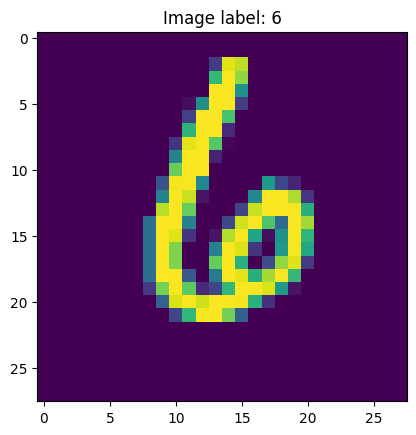

In [2]:
# do not change the code in the block below
# __________start of block__________

train_mnist_data = MNIST(
    ".", train=True, transform=torchvision.transforms.ToTensor(), download=True
)
test_mnist_data = MNIST(
    ".", train=False, transform=torchvision.transforms.ToTensor(), download=True
)


train_data_loader = torch.utils.data.DataLoader(
    train_mnist_data, batch_size=32, shuffle=True, num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_mnist_data, batch_size=32, shuffle=False, num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f"Image label: {_label}")
# __________end of block__________

Постройте модель ниже. Пожалуйста, не стройте переусложненную сеть, не стоит делать ее глубже четырех слоев (можно и меньше). Ваша основная задача – обучить модель и получить качество на отложенной (тестовой выборке) не менее 92% accuracy.

*Комментарий: для этого достаточно линейных слоев и функций активации.*

__Внимание, ваша модель должна быть представлена именно переменной `model`.__

In [23]:
num_features = 784
hid_size = 100
out_num = 10
activation = nn.ReLU

model = nn.Sequential()
model.add_module('l1', nn.Linear(num_features, hid_size))
model.add_module('activation1', activation())
model.add_module('l2', nn.Linear(hid_size, hid_size))
model.add_module('activation2', activation())
model.add_module('l3', nn.Linear(hid_size, out_num))

Локальные тесты для проверки вашей модели доступны ниже:

In [24]:
# do not change the code in the block below
# __________start of block__________
assert model is not None, "Please, use `model` variable to store your model"

try:
    x = random_batch[0].reshape(-1, 784)
    y = random_batch[1]

    # compute outputs given inputs, both are variables
    y_predicted = model(x)
except Exception as e:
    print("Something is wrong with the model")
    raise e


assert y_predicted.shape[-1] == 10, "Model should predict 10 logits/probas"

print("Everything seems fine!")
# __________end of block__________

Everything seems fine!


Настройте параметры модели на обучающей выборке. Рекомендуем поработать с различными оптимизаторами.

In [38]:
# Creating model instance
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 30
loss_func = nn.CrossEntropyLoss()

def train_model(model, train_loader, loss_fn, opt, n_epochs: int):
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # move data to target device
            ### YOUR CODE HERE

            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            ### YOUR CODE HERE
            y_pred = model(X_batch.reshape(-1, 784))
            loss = loss_func(y_pred, y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()
            ep_train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm   


        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))

    return model

In [39]:
model = train_model(model, train_data_loader, loss_func, opt, n_epochs)

/home/mikle/ML/Girafe/env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mikle/ML/Girafe/env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [44]:
torch.save(model.state_dict(), 'model_weights.pth')

Также, напоминаем, что в любой момент можно обратиться к замечательной [документации](https://pytorch.org/docs/stable/index.html) и [обучающим примерам](https://pytorch.org/tutorials/).  

Оценим качество классификации:

In [40]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in train_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
train_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [41]:
print(f"Neural network accuracy on train set: {train_acc:3.5}")

Neural network accuracy on train set: 0.99753


In [42]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in test_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
test_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [43]:
print(f"Neural network accuracy on test set: {test_acc:3.5}")

Neural network accuracy on test set: 0.9798


Проверка, что необходимые пороги пройдены:

In [45]:
assert test_acc >= 0.92, "Test accuracy is below 0.92 threshold"
assert (
    train_acc >= 0.91
), "Train accuracy is below 0.91 while test accuracy is fine. We recommend to check your model and data flow"

### Сдача задания
Загрузите файл `hw07_data_dict.npy` (ссылка есть на странице с заданием) и запустите код ниже для генерации посылки.

In [46]:
# do not change the code in the block below
# __________start of block__________
import os
import json

assert os.path.exists(
    "hw07_data_dict.npy"
), "Please, download `hw07_data_dict.npy` and place it in the working directory"


def get_predictions(model, eval_data, step=10):

    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx : idx + step].reshape(-1, 784))
            predicted_labels.append(y_predicted.argmax(dim=1))

    predicted_labels_np = torch.cat(predicted_labels).numpy()
    predicted_labels_str = ",".join([str(x) for x in list(predicted_labels)])
    return predicted_labels_np, predicted_labels_str


loaded_data_dict = np.load("hw07_data_dict.npy", allow_pickle=True)

train_labels_np, train_labels_str = get_predictions(
    model, torch.FloatTensor(loaded_data_dict.item()["train"])
)
test_labels_np, test_labels_str = get_predictions(
    model, torch.FloatTensor(loaded_data_dict.item()["test"])
)

submission_dict_str = {
    "train": train_labels_str,
    "test": test_labels_str,
}

submission_dict_np = {
    "train": train_labels_np,
    "test": test_labels_np,
}

np.save("submission_dict_hw07.npy", submission_dict_np, allow_pickle=True)
with open("submission_dict_hw07.json", "w") as iofile:
    json.dump(submission_dict_str, iofile)
print("File saved to `submission_dict_hw07.json` and `submission_dict_hw07.npy`")
# __________end of block__________

File saved to `submission_dict_hw07.json` and `submission_dict_hw07.npy`


На этом задание завершено. Поздравляем!